## 目標：利用CNN 和 SVM等模型 預測未來3日波動度 > 1.5%
## Y: 1=>大於 0=>小於
## 根據００３但是資料量減少

## 載入Library

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve



Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


## 資料載入 and 重新設定Header

In [2]:
df = pd.read_excel('data.xlsx', sheetname="Data003", header=None)

df.columns = ['日期', '月線差1','月線差2', '月線差3','月線差4', '月線差5', '月線差6','月線差7', '月線差8', \
              '月線差9', '月線差10', '季線差1', '季線差2','季線差3', '季線差4','季線差5', '季線差6','季線差7', \
              '季線差8','季線差9', '季線差10', 'DIF差1', 'DIF差2','DIF差3', 'DIF差4','DIF差5', 'DIF差6', \
              'DIF差7', 'DIF差8','DIF差9', 'DIF差10', '最高-最低', '最高-最低1','最高-最低2', '最高-最低3', \
              '最高-最低4', '最高-最低5','最高-最低6', '最高-最低7','最高-最低8', '最高-最低9', '指數漲跌差1', \
              '指數漲跌差2', '指數漲跌差3','指數漲跌差4', '指數漲跌差5','指數漲跌差6', '指數漲跌差7','指數漲跌差8', \
              '指數漲跌差9','指數漲跌差10','指數收開差1','指數收開差2','指數收開差3','指數收開差4','指數收開差5', \
              '指數收開差6','指數收開差7','指數收開差8','指數收開差9','指數收開差10','Close','波動度','Y']

df = df[df['波動度'] != 100] # 去除末端資料
df.tail()

,日期,月線差1,月線差2,月線差3,月線差4,月線差5,月線差6,月線差7,月線差8,月線差9,...,指數收開差4,指數收開差5,指數收開差6,指數收開差7,指數收開差8,指數收開差9,指數收開差10,Close,波動度,Y
1429,2017-12-13,-9.40,-22.05,-32.70,-49.30,-67.15,-88.20,-100.80,-106.90,-116.10,...,6,-20,-156,-27,48,-1,-74,10450,0.488038,0
1430,2017-12-14,-4.50,-13.90,-26.55,-37.20,-53.80,-71.65,-92.70,-105.30,-111.40,...,63,6,-20,-156,-27,48,-1,10527,0.664957,0
1431,2017-12-15,-10.90,-15.40,-24.80,-37.45,-48.10,-64.70,-82.55,-103.60,-116.20,...,-63,63,6,-20,-156,-27,48,10485,0.114449,0
1432,2017-12-18,-8.25,-19.15,-23.65,-33.05,-45.70,-56.35,-72.95,-90.80,-111.85,...,17,-63,63,6,-20,-156,-27,10501,0.057137,0
1433,2017-12-19,-16.40,-24.65,-35.55,-40.05,-49.45,-62.10,-72.75,-89.35,-107.20,...,17,17,-63,63,6,-20,-156,10457,0.726786,0


## X Y 資料確認

In [3]:
pd.value_counts(df['Y'].values, sort=False) # 統計 0 and 1 的數量

0    1052
1     382
dtype: int64

In [4]:
y = df['Y']
X = df.iloc[:,1:61]
X.head()

,月線差1,月線差2,月線差3,月線差4,月線差5,月線差6,月線差7,月線差8,月線差9,月線差10,...,指數收開差1,指數收開差2,指數收開差3,指數收開差4,指數收開差5,指數收開差6,指數收開差7,指數收開差8,指數收開差9,指數收開差10
0,25.55,56.40,88.55,116.10,153.90,192.90,235.75,275.55,312.75,349.05,...,-25,1,112,-10,0,85,-9,-31,-49,-57
1,24.00,49.55,80.40,112.55,140.10,177.90,216.90,259.75,299.55,336.75,...,-12,-25,1,112,-10,0,85,-9,-31,-49
2,15.25,39.25,64.80,95.65,127.80,155.35,193.15,232.15,275.00,314.80,...,-60,-12,-25,1,112,-10,0,85,-9,-31
3,13.10,28.35,52.35,77.90,108.75,140.90,168.45,206.25,245.25,288.10,...,-73,-60,-12,-25,1,112,-10,0,85,-9
4,8.60,21.70,36.95,60.95,86.50,117.35,149.50,177.05,214.85,253.85,...,42,-73,-60,-12,-25,1,112,-10,0,85


In [5]:
type(y)

pandas.core.series.Series

In [6]:
y.shape

(1434,)

## 訓練資料 and 測試資料

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [8]:
X_train.shape

(1147, 60)

In [9]:
X_test.shape

(287, 60)

In [10]:
y_train.shape

(1147,)

In [11]:
y_test.shape

(287,)

## 尺度標準化

In [12]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train

array([[-2.23338783, -2.01150845, -2.2128131 , ..., -2.14645365,
         0.40914928, -3.24947568],
       [-1.31945661, -1.41105141, -1.39615863, ...,  0.40118013,
         0.37466264, -2.55497926],
       [ 0.24823563,  0.08839498,  0.11884453, ...,  0.12943253,
         0.9264489 , -0.38245199],
       ..., 
       [ 0.66851057,  0.71768752,  0.81604462, ...,  0.77483309,
        -0.43577345,  0.02712282],
       [ 0.62181335,  0.72786476,  0.73679123, ...,  0.62197506,
         1.46099185, -0.649566  ],
       [ 0.34496557,  0.46156037,  0.61044525, ...,  1.01261224,
         0.9264489 , -1.37967762]])

In [13]:
X_test = sc.transform(X_test)
X_test

array([[ 0.84529288,  0.55315551,  0.57483866, ...,  0.33324323,
        -1.67729255,  0.27642923],
       [ 0.41834691,  0.3089018 ,  0.3497131 , ...,  0.06149563,
        -0.91858643, -1.55775363],
       [ 0.66517505,  0.69224442,  0.72760244, ...,  1.26737562,
         0.08152618, -1.23721682],
       ..., 
       [ 0.55510304,  0.48361105,  0.48409927, ...,  0.85975422,
         0.0987695 ,  1.20242446],
       [ 1.60245488,  1.52508173,  1.63499629, ...,  1.42023365,
         0.0125529 ,  0.93531045],
       [-1.28610146, -1.19732941, -1.24224625, ...,  0.0445114 ,
         0.8402323 , -0.7742192 ]])

## 訓練ANN

In [14]:
X_train.shape

(1147, 60)

In [15]:
classifier = Sequential()

classifier.add(Dense(units = 31, kernel_initializer = 'uniform', activation = 'relu', input_dim = 60))
classifier.add(Dense(units = 15, kernel_initializer = 'uniform', activation = 'relu', input_dim = 31))
classifier.add(Dense(units = 7, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


In [16]:
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 200)

Epoch 1/200
1147/1147 [==============================] - 0s - loss: 0.6520 - acc: 0.7210     
Epoch 2/200
1147/1147 [==============================] - 0s - loss: 0.5466 - acc: 0.7254     
Epoch 3/200
1147/1147 [==============================] - 0s - loss: 0.5378 - acc: 0.7254     
Epoch 4/200
1147/1147 [==============================] - 0s - loss: 0.5327 - acc: 0.7254     
Epoch 5/200
1147/1147 [==============================] - 0s - loss: 0.5279 - acc: 0.7254     
Epoch 6/200
1147/1147 [==============================] - 0s - loss: 0.5225 - acc: 0.7419     
Epoch 7/200
1147/1147 [==============================] - 0s - loss: 0.5176 - acc: 0.7446     
Epoch 8/200
1147/1147 [==============================] - 0s - loss: 0.5139 - acc: 0.7594     
Epoch 9/200
1147/1147 [==============================] - 0s - loss: 0.5091 - acc: 0.7611     
Epoch 10/200
1147/1147 [==============================] - 0s - loss: 0.5081 - acc: 0.7646     
Epoch 11/200
1147/1147 [==============================] - 0

1147/1147 [==============================] - 0s - loss: 0.1789 - acc: 0.9390     
Epoch 88/200
1147/1147 [==============================] - 0s - loss: 0.2084 - acc: 0.9250     
Epoch 89/200
1147/1147 [==============================] - 0s - loss: 0.1592 - acc: 0.9451     
Epoch 90/200
1147/1147 [==============================] - 0s - loss: 0.1401 - acc: 0.9599     
Epoch 91/200
1147/1147 [==============================] - 0s - loss: 0.1364 - acc: 0.9555     
Epoch 92/200
1147/1147 [==============================] - 0s - loss: 0.1314 - acc: 0.9590     
Epoch 93/200
1147/1147 [==============================] - 0s - loss: 0.1256 - acc: 0.9608     
Epoch 94/200
1147/1147 [==============================] - 0s - loss: 0.1218 - acc: 0.9625     
Epoch 95/200
1147/1147 [==============================] - 0s - loss: 0.1188 - acc: 0.9677     
Epoch 96/200
1147/1147 [==============================] - 0s - loss: 0.1232 - acc: 0.9599     
Epoch 97/200
1147/1147 [==============================] - 0s - 

1147/1147 [==============================] - 0s - loss: 0.0364 - acc: 0.9869     
Epoch 173/200
1147/1147 [==============================] - 0s - loss: 0.2691 - acc: 0.9276     
Epoch 174/200
1147/1147 [==============================] - 0s - loss: 0.1483 - acc: 0.9494     
Epoch 175/200
1147/1147 [==============================] - 0s - loss: 0.1097 - acc: 0.9555     
Epoch 176/200
1147/1147 [==============================] - 0s - loss: 0.0590 - acc: 0.9791     
Epoch 177/200
1147/1147 [==============================] - 0s - loss: 0.0353 - acc: 0.9887     
Epoch 178/200
1147/1147 [==============================] - 0s - loss: 0.0474 - acc: 0.9826     
Epoch 179/200
1147/1147 [==============================] - 0s - loss: 0.0486 - acc: 0.9852     
Epoch 180/200
1147/1147 [==============================] - 0s - loss: 0.0542 - acc: 0.9808     
Epoch 181/200
1147/1147 [==============================] - 0s - loss: 0.0322 - acc: 0.9878     
Epoch 182/200
1147/1147 [=============================

## 預測與驗證模型

In [17]:
y_pred = classifier.predict(X_test)

In [18]:
y_pred

array([[  3.86906116e-08],
       [  8.75079888e-04],
       [  2.37983189e-10],
       [  9.19203937e-01],
       [  3.25291985e-13],
       [  9.74811316e-01],
       [  9.94711041e-01],
       [  5.75757399e-03],
       [  2.71319615e-04],
       [  1.21930048e-01],
       [  2.03174823e-05],
       [  4.17179435e-05],
       [  3.60474378e-01],
       [  2.88660641e-11],
       [  1.86632364e-03],
       [  8.07392382e-07],
       [  4.80315794e-04],
       [  9.89515543e-01],
       [  2.68432836e-06],
       [  2.22888915e-03],
       [  3.00367683e-01],
       [  2.22338742e-04],
       [  1.53092788e-05],
       [  1.41364895e-02],
       [  5.52195939e-04],
       [  1.45802247e-07],
       [  9.43066955e-01],
       [  9.81037557e-01],
       [  2.49863463e-03],
       [  5.42030692e-01],
       [  4.18400377e-01],
       [  2.73134410e-01],
       [  1.08638835e-06],
       [  4.83903859e-05],
       [  2.48376955e-03],
       [  7.99924254e-01],
       [  4.93453667e-10],
 

In [19]:
y_pred = (y_pred > 0.5)
y_pred

array([[False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [

In [20]:
sum(y_pred.flatten().astype(int) == y_test) / len(y_test)

0.70034843205574915

In [21]:
cm = confusion_matrix(y_test, y_pred )
cm

array([[180,  40],
       [ 46,  21]])

## 繪製ANN 的 ROC Curve

In [22]:
y_pred = classifier.predict(X_test)
predicted = (y_pred > 0.5).flatten().astype(int)

In [23]:
predicted

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [24]:
confusion_matrix(y_test, predicted)

array([[180,  40],
       [ 46,  21]])

In [25]:
fpr_ary, tpr_ary, thresholds = roc_curve(y_test, y_pred)

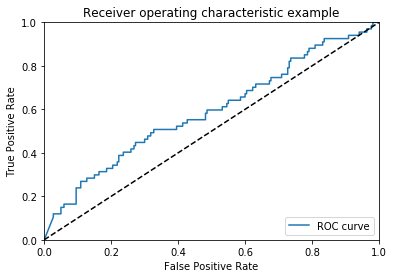

In [26]:
plt.plot(fpr_ary, tpr_ary, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## 比較不同分類器準確度

In [27]:
# ANN
classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf1 = DecisionTreeClassifier()
clf1.fit(X_train, y_train)

clf2 = SVC(probability = True)
clf2.fit(X_train, y_train)

clf3 = LogisticRegression()
clf3.fit(X_train, y_train)

clf4 = RandomForestClassifier()
clf4.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

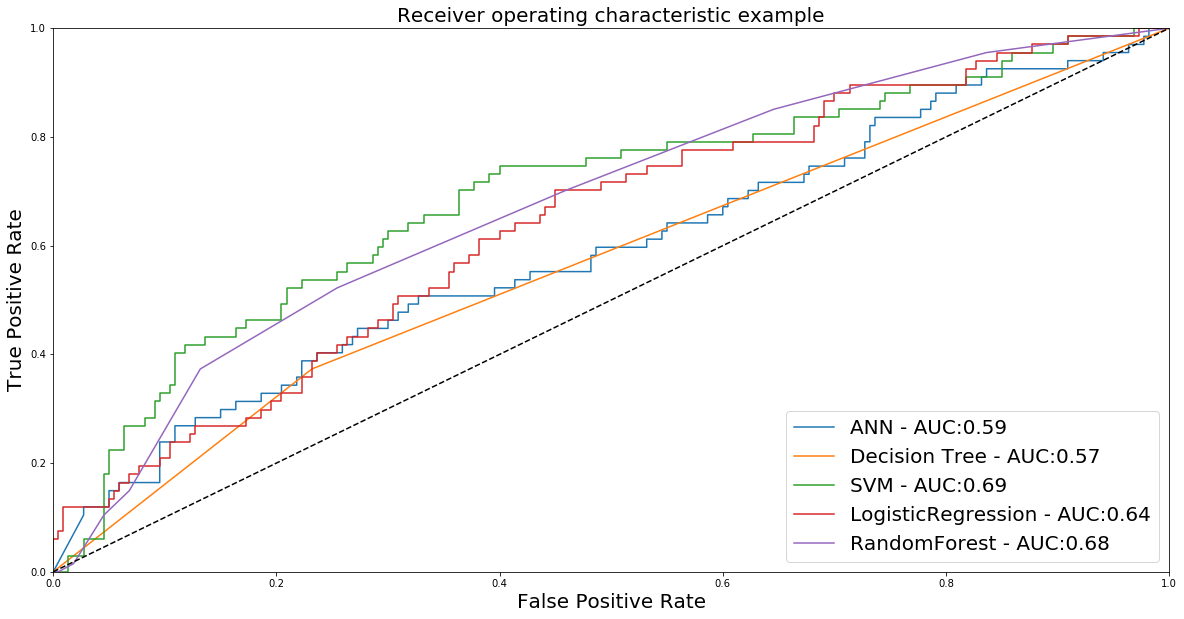

In [29]:
from sklearn.metrics import auc
plt.figure(figsize= [20,10])
for clf, title in zip([classifier,clf1,clf2,clf3, clf4], ['ANN','Decision Tree', 'SVM', 'LogisticRegression', 'RandomForest']):
    if title != 'ANN':
        probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    else:
        y_pred = clf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label='%s - AUC:%.2f'%(title, auc(fpr, tpr)) )
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('Receiver operating characteristic example', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.show()